## Extract LINCS genes from the TC data that we use for becnhmarking feature importance

TCGA cancer types
https://tcga-data.nci.nih.gov/docs/publications/tcga/

There is a problem with duplicated (??)

In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.datasets import make_biclusters, make_checkerboard, make_classification
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering, SpectralBiclustering
from sklearn.metrics import consensus_score

# Corr
from scipy.stats import spearmanr, pearsonr
from numpy import corrcoef

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '..', '..', 'utils_py'))
sys.path.append(utils_path)
import utils_all as utils

# Feature importance
pfi_path = os.path.abspath(os.path.join(file_path, '..', 'pfi'))
sys.path.append(pfi_path)
import pfi
import pfi_utils

import warnings
warnings.filterwarnings('ignore')

SEED=0

Using TensorFlow backend.


In [2]:
OUTDIR = os.path.join(file_path, 'data')
utils.make_dir(OUTDIR)

In [3]:
datapath = '/vol/ml/apartin/Benchmarks/Data/Pilot1/'

data_train_org = pd.read_csv(os.path.join(datapath, 'P1B1.dev.train.csv'), sep=',')
print(data_train_org.shape)

data_val_org = pd.read_csv(os.path.join(datapath, 'P1B1.dev.test.csv'), sep=',')
print(data_val_org.shape)

print(len(set(data_train_org.columns)))
print(len(set(data_val_org.columns)))

(3000, 60485)
(1000, 60485)
60485
60485


In [4]:
mm = pd.read_csv(os.path.join(datapath, 'lincs1000.tsv'), sep='\t')
print(mm.shape)

(978, 5)


In [5]:
data_train = data_train_org[['case_id', 'cancer_type'] + mm['gdc'].tolist()]  # Extract lincs from the whole dataset
data_val   = data_val_org[['case_id', 'cancer_type'] + mm['gdc'].tolist()]  # Extract lincs from the whole dataset
print(data_train.shape)
print(data_val.shape)
print(len(set(data_train.columns)))
print(len(set(data_val.columns)))

(3000, 980)
(1000, 980)
980
980


### <font color=red>'Problem with mapping (not unique) - start'</font> 
'PIK3R3' appears 3 times.
This actually creates a lot of problems (duplicates columns).

In [6]:
print(len(mm['gdc'].unique()))
print(len(mm['symbol'].unique()))

978
976


In [7]:
def find_duplicate_values_in_list(org_list):
    # org_list = [20,30,20,30,40,50,15,11,20,40,50,15,6,7]
    org_list.sort()
    unq_list = sorted(set(org_list))
    dup_list =[]
    for i in range(len(unq_list)):
        if (org_list.count(unq_list[i]) > 1):
            dup_list.append(unq_list[i])
    print(dup_list)

In [8]:
find_duplicate_values_in_list(org_list=mm['symbol'].tolist())

['PIK3R3']


In [9]:
sum(mm['symbol']=='PIK3R3')

3

In [10]:
# Map lincs gene names
col_mapping = {mm.loc[g, 'gdc']: mm.loc[g, 'symbol'] for g in range(mm.shape[0])}
data_train = data_train.rename(columns=col_mapping)
data_val = data_val.rename(columns=col_mapping)
len(set(data_train.columns))

978

In [11]:
data_train['PIK3R3'][:3]

,PIK3R3,PIK3R3,PIK3R3
0,19.1,0.0,0.0
1,19.7,0.0,0.0
2,17.9,0.0,0.0


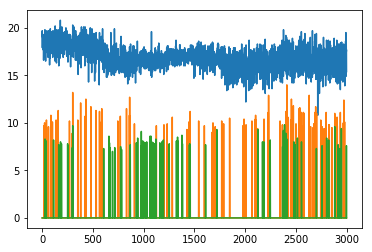

In [12]:
plt.plot(data_train['PIK3R3']);

In [13]:
# Drop the duplicated col
data_train.drop(columns=['PIK3R3'], inplace=True)
data_val.drop(columns=['PIK3R3'], inplace=True)
print(data_train.shape)
print(data_val.shape)

(3000, 977)
(1000, 977)


### <font color=red>'Problem with mapping (not unique) - end'</font>

In [14]:
# Sort gene names
print(data_train.shape)
print(data_val.shape)

sorted_gene_names = sorted(data_train.columns[2:].tolist())
data_train = data_train[['case_id', 'cancer_type'] + sorted_gene_names]
data_val = data_val[['case_id', 'cancer_type'] + sorted_gene_names]

print(data_train.shape)
print(data_val.shape)

(3000, 977)
(1000, 977)
(3000, 977)
(1000, 977)


In [15]:
# Drop 'case_id'
data_train.drop(columns='case_id', inplace=True)
data_val.drop(columns='case_id', inplace=True)

# Rename 'cancer_type' -> 'y'
data_train.rename(columns={'cancer_type': 'y'}, inplace=True)
data_val.rename(columns={'cancer_type': 'y'}, inplace=True)

In [16]:
data_train['y'].value_counts()

Lung Squamous Cell Carcinoma             300
Skin Cutaneous Melanoma                  300
Others                                   300
Uterine Corpus Endometrial Carcinoma     300
Head and Neck Squamous Cell Carcinoma    300
Lung Adenocarcinoma                      300
Thyroid Carcinoma                        300
Brain Lower Grade Glioma                 300
Prostate Adenocarcinoma                  300
Breast Invasive Carcinoma                300
Name: y, dtype: int64

In [17]:
data_val['y'].value_counts()

Head and Neck Squamous Cell Carcinoma    100
Brain Lower Grade Glioma                 100
Lung Squamous Cell Carcinoma             100
Prostate Adenocarcinoma                  100
Skin Cutaneous Melanoma                  100
Lung Adenocarcinoma                      100
Others                                   100
Breast Invasive Carcinoma                100
Uterine Corpus Endometrial Carcinoma     100
Thyroid Carcinoma                        100
Name: y, dtype: int64

In [18]:
# Rename cancer type names (shorter names)
map_cancer_names = {
    'Brain Lower Grade Glioma': 'Brain [LGG]',
    'Breast Invasive Carcinoma': 'Breast [BRCA]',
    'Head and Neck Squamous Cell Carcinoma': 'Head&Neck [HNSC]',
    'Lung Adenocarcinoma': 'Lung [LUAD]',
    'Lung Squamous Cell Carcinoma': 'Lung [LUSC]',
    'Others': 'Others',
    'Prostate Adenocarcinoma': 'Prostate [PRAD]',
    'Skin Cutaneous Melanoma': 'Skin [SKCM]',
    'Thyroid Carcinoma': 'Thyroid [THCA]',
    'Uterine Corpus Endometrial Carcinoma': 'Uterine [UCEC]'}

data_train['y'] = data_train['y'].map(lambda s: map_cancer_names[s])
data_val['y'] = data_val['y'].map(lambda s: map_cancer_names[s])

In [19]:
data_train['y'].value_counts()

Breast [BRCA]       300
Skin [SKCM]         300
Head&Neck [HNSC]    300
Others              300
Thyroid [THCA]      300
Brain [LGG]         300
Uterine [UCEC]      300
Lung [LUAD]         300
Prostate [PRAD]     300
Lung [LUSC]         300
Name: y, dtype: int64

In [20]:
data_val['y'].value_counts()

Breast [BRCA]       100
Skin [SKCM]         100
Uterine [UCEC]      100
Lung [LUAD]         100
Lung [LUSC]         100
Head&Neck [HNSC]    100
Others              100
Prostate [PRAD]     100
Thyroid [THCA]      100
Brain [LGG]         100
Name: y, dtype: int64

In [21]:
y_train = data_train['y'].values
y_val = data_val['y'].values
y_enc = LabelEncoder()

In [22]:
y_train = y_enc.fit_transform(y_train)
y_val = y_enc.transform(y_val)

In [23]:
data_train['y'] = y_train
data_val['y'] = y_val

In [24]:
# y_encoded = pd.DataFrame(data={'label': np.arange(0, len(y_enc.classes_)), 'type': y_enc.classes_})
# y_encoded.to_csv(os.path.join(OUTDIR, 'P1B1.y.enc.ap'), sep='\t', index=False)
y_encoded = pd.DataFrame(data={'code': np.arange(0, len(y_enc.classes_)), 'label': y_enc.classes_})
y_encoded.to_csv(os.path.join(OUTDIR, 'P1B1.y.enc.ap'), sep='\t', index=False)

In [25]:
y_encoded

,code,label
0,0,Brain [LGG]
1,1,Breast [BRCA]
2,2,Head&Neck [HNSC]
3,3,Lung [LUAD]
4,4,Lung [LUSC]
5,5,Others
6,6,Prostate [PRAD]
7,7,Skin [SKCM]
8,8,Thyroid [THCA]
9,9,Uterine [UCEC]


In [26]:
# Shuffle the training values
data_train = data_train.sample(n=data_train.shape[0], axis=0, replace=False, random_state=SEED).reset_index(drop=True)

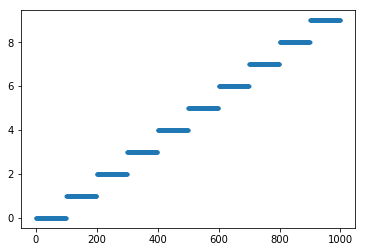

In [27]:
# Sort the val values by the target label
data_val = data_val.sort_values('y', ascending=True).reset_index(drop=True)
plt.plot(data_val['y'], '.');

In [28]:
# data_train.to_csv(os.path.join(file_path, 'data', 'P1B1.dev.train.lincs.csv'), index=False)
# data_val.to_csv(os.path.join(file_path, 'data', 'P1B1.dev.test.lincs.csv'), index=False)
data_train.to_csv(os.path.join(OUTDIR, 'P1B1.dev.train.lincs.ap'), sep='\t', index=False)
data_val.to_csv(os.path.join(OUTDIR, 'P1B1.dev.test.lincs.ap'), sep='\t', index=False)